In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt

from scipy.stats import norm

In [2]:
SOFR_df = pd.read_excel('hist_data.xlsm', sheet_name = 'SofrCurve', index_col = 'Tenor')
SOFR_df.columns = [col.strftime('%Y-%m-%d') if isinstance(col, dt.datetime) else col for col in SOFR_df.columns]
SOFR_df.head(3)

,T,2022-10-31,2022-11-01,2022-11-02,2022-11-03,2022-11-04,2022-11-07,2022-11-08,2022-11-09,2022-11-10,...,2023-10-17,2023-10-18,2023-10-19,2023-10-20,2023-10-23,2023-10-24,2023-10-25,2023-10-26,2023-10-27,2023-10-30
Tenor,,,,,,,,,,,,,,,,,,,,,
1D,0.002778,0.039191,0.039604,0.039948,0.040389,0.045965,0.040224,0.040339,0.040373,0.052075,...,0.052964,0.053038,0.053050,0.053072,0.053090,0.053105,0.052981,0.053047,0.052989,0.052967
1M,0.083333,0.038721,0.039023,0.039286,0.039585,0.042343,0.039258,0.039211,0.039193,0.043694,...,0.053114,0.053102,0.053086,0.053046,0.053077,0.053084,0.053057,0.053089,0.053040,0.053053
2M,0.166667,0.038670,0.038886,0.039100,0.039350,0.038795,0.039460,0.039420,0.039483,0.038786,...,0.053374,0.053284,0.053226,0.053128,0.053191,0.053202,0.053259,0.053218,0.053185,0.053265


## 1. DATA PREPARATION

### 1.1. DEFINE RE-USABLE FUNCTIONS

#### 1.1.1. Select the relevant data
* As the swap has annual payments and maturity of 10 years, we only need the SOFR corresponding to the tenors from 1Y to 10Y.

In [3]:
def Swap_data_prep(SOFR_df, Tenor_col = 'T', T_min = 1, T_max = 10): 
    """
    Some data pre processing so that the function is re-usable for other similar data and projects

    Inputs:
    - SOFR_df (DataFrame): raw data containing the tenors in years and the SOFR
    - T_min (float): the minimum tenor to be used, representing the payment structure, i.e. T = 1 for annual payment
    - T_max (float): represent the maturity of the swap
    
    Outputs:
    - Swap_df (DataFrame): a DataFrame with relevant SOFR for swap valuation
    """

    # Sorting the data by Tenors
    Swap_df = SOFR_df.copy()
    Swap_df[Tenor_col] = pd.to_numeric(Swap_df[Tenor_col], errors='coerce')
    Swap_df = Swap_df.sort_values(by = Tenor_col)

    # Slicing the relevant part of the data according to the maturity of the instrument
    Swap_df = Swap_df[Swap_df[Tenor_col].between(T_min, T_max)]

    return Swap_df

In [4]:
Swap_df = Swap_data_prep(SOFR_df)
Swap_df

,T,2022-10-31,2022-11-01,2022-11-02,2022-11-03,2022-11-04,2022-11-07,2022-11-08,2022-11-09,2022-11-10,...,2023-10-17,2023-10-18,2023-10-19,2023-10-20,2023-10-23,2023-10-24,2023-10-25,2023-10-26,2023-10-27,2023-10-30
Tenor,,,,,,,,,,,,,,,,,,,,,
1Y,1.0,0.046449,0.046970,0.047203,0.047894,0.047500,0.047929,0.047589,0.047479,0.045989,...,0.053225,0.053163,0.052750,0.052348,0.052389,0.052503,0.052653,0.052243,0.052115,0.052245
2Y,2.0,0.044583,0.045022,0.045496,0.046594,0.046097,0.046633,0.046046,0.045585,0.042912,...,0.049497,0.049611,0.049204,0.048366,0.048027,0.048399,0.048791,0.048044,0.047758,0.047904
3Y,3.0,0.042002,0.042344,0.042749,0.043833,0.043385,0.043884,0.043209,0.042645,0.039631,...,0.046978,0.047304,0.047169,0.046151,0.045582,0.045999,0.046595,0.045645,0.045284,0.045429
4Y,4.0,0.040318,0.040614,0.040868,0.041825,0.041503,0.041916,0.041182,0.040704,0.037584,...,0.045605,0.046034,0.046195,0.045156,0.044508,0.044850,0.045594,0.044538,0.044200,0.044345
5Y,5.0,0.039297,0.039522,0.039675,0.040507,0.040303,0.040635,0.039857,0.039489,0.036386,...,0.044929,0.045414,0.045751,0.044758,0.044048,0.044305,0.045200,0.044086,0.043762,0.043928
6Y,6.0,0.038534,0.038658,0.038776,0.039537,0.039421,0.039734,0.038881,0.038647,0.035572,...,0.044567,0.045049,0.045511,0.044604,0.043871,0.044036,0.045017,0.043893,0.043636,0.043794
7Y,7.0,0.037979,0.038007,0.038117,0.038820,0.038782,0.039111,0.038192,0.038085,0.035027,...,0.044333,0.044795,0.045361,0.044548,0.043806,0.043889,0.044911,0.043808,0.043643,0.043779
8Y,8.0,0.037648,0.037605,0.037704,0.038328,0.038373,0.038715,0.037781,0.037765,0.034725,...,0.044178,0.044635,0.045287,0.044554,0.043784,0.043816,0.044867,0.043795,0.043702,0.043828
9Y,9.0,0.037465,0.037368,0.037458,0.038002,0.038128,0.038473,0.037560,0.037612,0.034598,...,0.044081,0.044545,0.045266,0.044606,0.043798,0.043798,0.044876,0.043829,0.043793,0.043915


#### 1.1.1. Swap Valuation

In [5]:
def Swap_Valuation_payer(Swap_df, Tenor_col = 'T', swap_rate = 0.042, notional = 1e8, 
                         valuation_date = '2022-10-31'):
    """
    Function to value the Swap payer for a given period. Parameters are set dynamically.

    Inputs:
    - Swap_df (DataFrame): DataFrame with relevant tenors (in years) and the SOFR to value the swap
    - swap_rate (float): the par swap rate / the strike
    - notional (float): the notional principal
    - valuation_date (str): Column corresponds to the valuation date, containing SOFR for tenors.

    Outputs:
    - Swap_calc (DF): DataFrame of detail calculation for double check
    - PV_Swap (float): value of the Swap payer
    """

    Swap_calc = Swap_df.copy()
    
    # Extracting the column name Zero rates
    val_date_idx = Swap_calc.columns.get_loc(valuation_date)
    zero_col = Swap_calc.columns[val_date_idx]

    # Sorting the data by Tenors
    Swap_calc[Tenor_col] = pd.to_numeric(Swap_calc[Tenor_col], errors='coerce')
    Swap_calc = Swap_calc.sort_values(by = Tenor_col)
    
    # Main calculation of swap values
    Swap_calc[zero_col] = pd.to_numeric(Swap_calc[zero_col], errors='coerce') # ensure the zero col are also numeric
    Swap_calc['Di'] = np.exp( -Swap_calc[Tenor_col] * Swap_calc[zero_col] )

    # Calculate the PV of the legs
    PV_float = 1 - Swap_calc['Di'].iloc[-1] # the iloc[-1] corresponds to the max tenor
    PV_fixed = Swap_calc['Di'].sum() * swap_rate

    # Calculate the PV of the Swap payers by netting the PV of the legs
    PV_Swap = (PV_float - PV_fixed) * notional

    Swap_calc = Swap_calc[[Tenor_col, zero_col, 'Di']]

    return Swap_calc, PV_Swap

In [6]:
valuation_date = '2023-10-30'

Swap_calc, PV_Swap = Swap_Valuation_payer(Swap_df, valuation_date = valuation_date)

print(f'The value of the swap on {valuation_date} is ${PV_Swap}')

print('We can double check by having a look at the selected data and the calculated Discount factors:')
print(Swap_calc)

The value of the swap on 2023-10-30 is $2442901.9998463253
We can double check by having a look at the selected data and the calculated Discount factors:
          T  2023-10-30        Di
Tenor                            
1Y      1.0    0.052245  0.949097
2Y      2.0    0.047904  0.908638
3Y      3.0    0.045429  0.872591
4Y      4.0    0.044345  0.837462
5Y      5.0    0.043928  0.802808
6Y      6.0    0.043794  0.768923
7Y      7.0    0.043779  0.736051
8Y      8.0    0.043828  0.704247
9Y      9.0    0.043915  0.673524
10Y    10.0    0.044023  0.643887


In [7]:
# This function is not really needed for this project, but it can be helpful for our future career
# Following the swap valuation on a given day, we have a function to value the swap on all given days and plot the value overtime

def Swap_Valuation_mult(Swap_df, Tenor_col = 'T', swap_rate = 0.042, notional = 1e8, plot = False):
    """
    Value the swap on all given days and plot the value overtime; employing the predefined Swap_Valuation_payer for a given day.
    
    Inputs:
    - Swap_df (DataFrame): DataFrame with relevant tenors (in years) and the SOFR to value the swap
    - swap_rate (float): the par swap rate / the strike
    - notional (float): Notional principal of the swap
    
    Outputs:
    - PV_swap_df (DataFrame): A DataFrame with columns ['Date', 'PV_Swap'] for each valuation date.
    """
    
    # Assuming the first column is the tenor (in years) and the rest of the columns are valuation dates.
    # We can make this more adaptive when neede by generating a list of the SOFR dates
    valuation_dates = Swap_df.columns[1:]
    PV_swap_all = []
    
    # Loop through each valuation date, compute swap value, and append the result.
    # Employing our pre-defined function of swap payer valuation
    for date in valuation_dates:
        _, PV_Swap = Swap_Valuation_payer(Swap_df, Tenor_col = Tenor_col, swap_rate = swap_rate, 
                                          notional = notional, valuation_date = date)
        PV_swap_all.append(PV_Swap)
    
    # Create a DataFrame for all the dates and corresponding swap values
    Swap_calc_mult = pd.DataFrame({'Date': valuation_dates, 'V_Swap_payer': PV_swap_all})
    
    # Convert Date column to datetime
    Swap_calc_mult['Date'] = pd.to_datetime(Swap_calc_mult['Date'])

    if plot:
        plt.figure(figsize = (14,5))
        plt.plot(Swap_calc_mult['Date'], Swap_calc_mult['V_Swap_payer'])
        plt.xlabel('Valuation Date')
        plt.ylabel('Swap Payer Value')
        plt.title('Swap Payer Value Over Time', color = 'darkblue')
        plt.grid(True, alpha = 0.3)
    
    return Swap_calc_mult

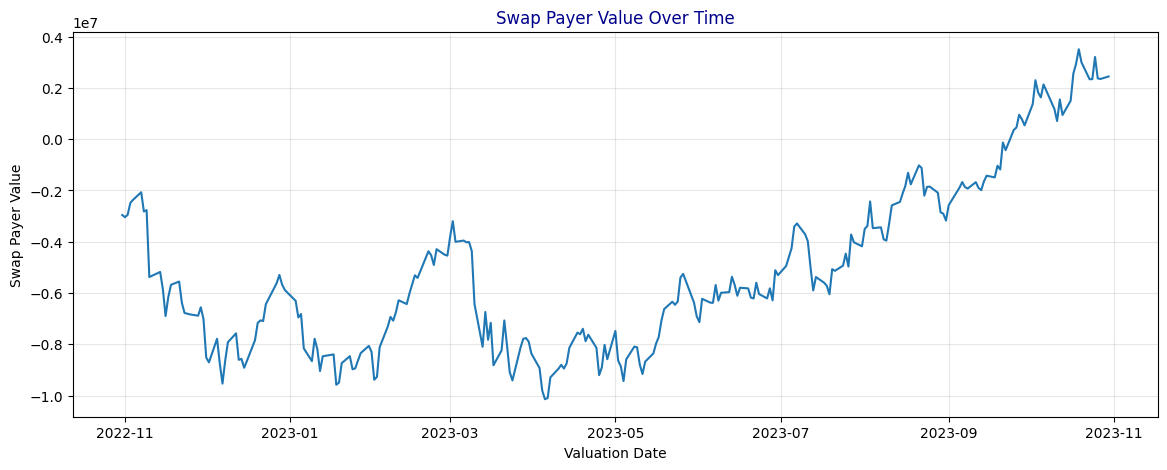

In [8]:
Swap_calc_mult = Swap_Valuation_mult(Swap_df, plot = True)

In [9]:
Swap_calc_mult

,Date,V_Swap_payer
0,2022-10-31,-2.958503e+06
1,2022-11-01,-3.044883e+06
2,2022-11-02,-2.954226e+06
3,2022-11-03,-2.487463e+06
4,2022-11-04,-2.367458e+06
...,...,...
246,2023-10-24,2.338622e+06
247,2023-10-25,3.202746e+06
248,2023-10-26,2.367237e+06
249,2023-10-27,2.345707e+06


#### 1.2. Partial DV01 (PV01)

In [10]:
def Swap_PV01_calc(Swap_df, Tenor_col = 'T', swap_rate = 0.042, notional = 1e8, 
                   valuation_date = '2023-10-30'):
    """
    Calculate Partial DV01 (PV01) for each tenor by bumping the zero rate for that tenor by 1 bp.
    
    Inputs:
    - Swap_df (DataFrame): DataFrame with tenors and SOFR data.
    - swap_rate (float): the par swap rate / the strike.
    - notional (float): the notional principal.
    - valuation_date (str): the column corresponding to the valuation date containing SOFR.
    
    Outputs:
    - PV01_df (DataFrame): A DataFrame with columns ['T', 'PV01'] containing the PV01 for each tenor.
    """

    calc_df = Swap_df.copy()
    
    # Calculate the baseline swap payer value using Swap_Valuation_payer
    _, PV_Swap_baseline = Swap_Valuation_payer(calc_df, Tenor_col = Tenor_col, swap_rate = swap_rate, 
                                               notional = notional, valuation_date = valuation_date)
    
    # Loop over each row in the DataFrame (each row corresponds to one tenor) to calculate PV01
    PV01_list = []
    tenors_list = []
    
    for idx, row in calc_df.iterrows():
        df_bumped = calc_df.copy()
        df_bumped.loc[idx, valuation_date] = df_bumped.loc[idx, valuation_date] + 1e-4 # bump 1 bp = 0.0001
        
        # Recalculate the swap value with the bumped rate
        _, PV_Swap_bumped = Swap_Valuation_payer(df_bumped, Tenor_col = Tenor_col, swap_rate = swap_rate, 
                                                 notional = notional, valuation_date = valuation_date)
        
        # Calculate Partial DV01
        PV01 = (PV_Swap_bumped - PV_Swap_baseline) / 1e-4
        PV01_list.append(PV01)
        tenors_list.append(row[Tenor_col])
    
    # Create a DataFrame
    PV01_df = pd.DataFrame({'T': tenors_list, 'PV01': PV01_list})
    
    return PV01_df

In [11]:
PV01_df = Swap_PV01_calc(Swap_df, valuation_date = '2023-10-30')
PV01_df

,T,PV01
0,1.0,3.986007e+06
1,2.0,7.631797e+06
2,3.0,1.099300e+07
3,4.0,1.406655e+07
4,5.0,1.685475e+07
5,6.0,1.937106e+07
6,7.0,2.163234e+07
7,8.0,2.365323e+07
8,9.0,2.544777e+07
9,10.0,6.705953e+08


### 1.2. EQUITY PREPARATION

In [12]:
AAPL_df = pd.read_excel('hist_data.xlsm', sheet_name = 'AAPL', index_col = 'Date')
AAPL_df.columns = ['AAPL']

MSFT_df = pd.read_excel('hist_data.xlsm', sheet_name = 'MSFT', index_col = 'Date')
MSFT_df.columns = ['MSFT']

F_df = pd.read_excel('hist_data.xlsm', sheet_name = 'F', index_col = 'Date')
F_df.columns = ['F']

BAC_df = pd.read_excel('hist_data.xlsm', sheet_name = 'BAC', index_col = 'Date')
BAC_df.columns = ['BAC']

stock_prices = pd.concat([AAPL_df, MSFT_df, F_df, BAC_df], axis = 1)
stock_returns = stock_prices.pct_change().dropna()
stock_returns

,AAPL,MSFT,F,BAC
Date,,,,
2022-11-01,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.003902,0.029270,0.014064,0.005980
...,...,...,...,...
2023-10-24,0.002543,0.003674,-0.007840,-0.003911
2023-10-25,-0.013492,0.030678,0.013169,0.003141
2023-10-26,-0.024606,-0.037514,-0.016464,0.022309


### 1.3. PORTFOLIO PREPARATION

### 1.3.1. Weight Vector

In [13]:
PV01_weights = PV01_df['PV01'].to_numpy()

stock_weights = np.full(4, 1e6)

risk_factor_weights = np.concatenate((PV01_weights, stock_weights))
risk_factor_weights
# OK so this is the WEIGHT VECTOR of the risk factors for later use

array([3.98600677e+06, 7.63179678e+06, 1.09930011e+07, 1.40665536e+07,
       1.68547510e+07, 1.93710561e+07, 2.16323359e+07, 2.36532276e+07,
       2.54477691e+07, 6.70595263e+08, 1.00000000e+06, 1.00000000e+06,
       1.00000000e+06, 1.00000000e+06])

### 1.3.2. Portfolio mean and variance

In [14]:
SOFR_d = Swap_df.T.iloc[1:].diff().dropna()
SOFR_d.columns.name = None
SOFR_d.index.name = 'Date'
SOFR_d.index = pd.to_datetime(SOFR_d.index)

In [15]:
# The data table of the changes in the risk factors
P_rates_changes = pd.concat([SOFR_d, stock_returns], axis = 1)
P_rates_changes.head()

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,AAPL,MSFT,F,BAC
Date,,,,,,,,,,,,,,
2022-11-01,0.000521,0.000439,0.000342,0.000296,0.000225,0.000124,0.000029,-0.000043,-0.000097,-0.000144,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,0.000234,0.000474,0.000404,0.000254,0.000153,0.000118,0.000109,0.000099,0.000090,0.000091,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,0.000690,0.001098,0.001085,0.000957,0.000832,0.000761,0.000704,0.000624,0.000545,0.000495,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.000394,-0.000497,-0.000448,-0.000322,-0.000204,-0.000116,-0.000038,0.000045,0.000126,0.000192,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.000429,0.000536,0.000499,0.000413,0.000332,0.000313,0.000328,0.000342,0.000345,0.000339,0.003902,0.029270,0.014064,0.005980


In [16]:
# Mean rate changes
P_rates_changes_mean = P_rates_changes.mean()
P_rates_changes_mean

1Y      0.000023
2Y      0.000013
3Y      0.000014
4Y      0.000016
5Y      0.000019
6Y      0.000021
7Y      0.000023
8Y      0.000025
9Y      0.000026
10Y     0.000027
AAPL    0.000568
MSFT    0.001692
F      -0.000619
BAC    -0.001105
dtype: float64

In [17]:
# Mean daily change of the portfolio value
P_mean_changes = risk_factor_weights @ P_rates_changes_mean
P_mean_changes

np.float64(21463.461322980354)

In [18]:
# Covar matrix
P_covar = P_rates_changes.cov()

In [19]:
# P_covar

In [20]:
# risk_factor_weights.shape
# P_covar.shape

In [21]:
# Mean daily volatility of the portfolio value
P_var = risk_factor_weights.T @ P_covar @ risk_factor_weights
P_sd = np.sqrt(P_var)
P_sd

np.float64(580135.9506267526)

## 2. PARAMETRIC VAR

2.1. We can find the 95th percentile by using: 

$$\text{Parametric~VaR~}95 = \overline{\Delta P} + z \times \sigma_P$$

In [22]:
# Recall the Mean daily change of the portfolio value
P_mean_changes = risk_factor_weights @ P_rates_changes_mean
P_mean_changes

np.float64(21463.461322980354)

In [23]:
# Recall the Standard deviation of portfolio value change
P_covar = P_rates_changes.cov()
P_var = risk_factor_weights.T @ P_covar @ risk_factor_weights
P_sd = np.sqrt(P_var)
P_sd

np.float64(580135.9506267526)

In [24]:
# Confidence level and corresponding Z-score
confidence_level = 0.95
z = norm.ppf(1 - confidence_level)
z

np.float64(-1.644853626951472)

In [25]:
# Calculate Parametric VaR using the provided formula
VaR = P_mean_changes + z * P_sd
print(f"Parametric VaR at {confidence_level * 100}% confidence level: {VaR}")

Parametric VaR at 95.0% confidence level: -932775.2611903737


Parameterized VaR will not lose more than 932775.2611903738 at 95% confidence level

## 3. HISTORICAL VAR

In [43]:
nan_counts = P_rates_changes.isna().sum()
print("NaN counts per column in P_rates_changes:\n", nan_counts)
P_rates_changes = P_rates_changes.dropna()
portfolio_value_changes_risk_based = P_rates_changes @ risk_factor_weights
historical_var_risk_based = np.percentile(portfolio_value_changes_risk_based, 5)
historical_var_risk_based

NaN counts per column in P_rates_changes:
 1Y      0
2Y      0
3Y      0
4Y      0
5Y      0
6Y      0
7Y      0
8Y      0
9Y      0
10Y     0
AAPL    0
MSFT    0
F       0
BAC     0
dtype: int64


np.float64(-980180.0116969945)

1. Risk-Based Approach

$$
\Delta P = w^T \cdot \Delta X
$$

$$
\text{VaR}_{\alpha} = -\text{Percentile}_{1-\alpha}(\Delta P)
$$


In [28]:
# Compute portfolio value changes using dot product
portfolio_value_changes_risk_based = P_rates_changes @ risk_factor_weights

In [29]:
# Compute Historical VaR as the 5th percentile (negative of 95% percentile)
historical_var_risk_based = np.percentile(portfolio_value_changes_risk_based, 5)

2. Full Revaluation Approach

$$
P_{\text{new}} = P_{\text{baseline}} + \text{New Swap Value} + \text{New Equity Value}
$$

$$
\Delta P_{\text{full}} = P_{\text{new}} - P_{\text{baseline}}
$$

$$
\text{VaR}_{\alpha} = -\text{Percentile}_{1-\alpha}(\Delta P_{\text{full}})
$$


In [31]:
#1: Compute Baseline Portfolio Value
_, baseline_swap_value = Swap_Valuation_payer(Swap_df, valuation_date='2023-10-30')

In [32]:
# Assume $1M in each stock, total equity position = $4M
baseline_equity_value = 4e6

In [33]:
# Compute total baseline portfolio value
baseline_portfolio_value = baseline_swap_value + baseline_equity_value

In [34]:
#2:Generate New SOFR Set by Adding Historical Daily Changes
SOFR_revalued = Swap_df.T.iloc[-1] + SOFR_d.cumsum()
SOFR_revalued = SOFR_revalued.T

In [35]:
#3:Compute New Swap Values for Each Historical Date
new_swap_values = []
for date in SOFR_d.index:
    new_swap_df = Swap_df.copy()
    new_swap_df.iloc[:, 1:] = SOFR_revalued[date].values.reshape(-1, 1)  # Update SOFR rates
    _, swap_value = Swap_Valuation_payer(new_swap_df, valuation_date='2023-10-30')
    new_swap_values.append(swap_value)

In [36]:
#4:Compute New Equity Values
new_equity_values = stock_prices.iloc[-1] + stock_returns.cumsum()
new_equity_values = new_equity_values * 1e6  # $1M per stock

In [37]:
#5:Compute New Portfolio Values (Swap + Equity)
new_portfolio_values = np.array(new_swap_values) + new_equity_values.sum(axis=1).values

In [38]:
#6:Compute Daily Changes in Portfolio Value
portfolio_value_changes_full_reval = new_portfolio_values - baseline_portfolio_value

In [39]:
#7:Compute Historical VaR (Full Revaluation) as the 5th percentile
historical_var_full_reval = np.percentile(portfolio_value_changes_full_reval, 5)

In [40]:
# Risk-Based Approach
print("1. Risk-Based Approach")
print(f"VaR (95% Confidence Level): ${historical_var_risk_based:,.2f}\n")

1. Risk-Based Approach
VaR (95% Confidence Level): $-980,180.01



In [41]:
# Full Revaluation Approach
print("2. Full Revaluation Approach")
print(f"VaR (95% Confidence Level): ${historical_var_full_reval:,.2f}\n")

2. Full Revaluation Approach
VaR (95% Confidence Level): $531,789,882.67



## 4. MONTE CARLO VAR